<a href="https://colab.research.google.com/github/KWANGJAEIM/AI_project/blob/main/%EC%83%81%EC%B6%94%EC%83%9D%EC%9C%A1ver3ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd "./drive/My Drive/Data/lettuce"

/content/drive/My Drive/Data/lettuce


In [3]:
!pip install lightgbm==3.3.2
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory

In [4]:
# -*- coding: utf-8 -*-
# General Library
import warnings
warnings.filterwarnings('ignore')

import os, sys
import random
import numpy as np
import pandas as pd
from time import time
from glob import glob
from pathlib import Path
import re
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Machine Learning Library
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb

# Setting Random Seed
SEED = 123
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setting Korean font
from sys import platform
if platform == "linux" or platform == "linux2":
    plt.rc('font', family='NanumBarunGothic')
else:
    plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

#########################################################################################################
DATA_DIR = 'lettuce/'
if not os.path.isdir(DATA_DIR):
    os.mkdir(DATA_DIR)

RESULTS_DIR = 'results/'
if not os.path.isdir(RESULTS_DIR):
    os.mkdir(RESULTS_DIR)

TEST_OUTPUT = 'answer_example.csv'

#########################################################################################################
NUM_BOOST_ROUNDS = 100
METRIC = 'fair'

categoricals = []

FEATURES = ['DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '일간누적백색광량',  '일간누적적색광량', '일간누적청색광량',
       '일간누적총광량', ]      
FEATURES_sum= ['DAT', 'obs_time', 
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량' ]      
FEATURES2 =['내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES3 = [ 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치',
           '시간당백색광량',  '시간당적색광량', '시간당청색광량',
       '시간당총광량', ]
FEATURES_dacon = ['DAT','obs_time', '내부온도관측치', '내부습도관측치', 'ec관측치', '시간당총광량']
print('Numpy: %s'%(np.__version__))
print('Pandas: %s'%(pd.__version__))
print('LightGBM: %s'%(lgb.__version__))
print('Python: %s'%sys.version)



Numpy: 1.21.6
Pandas: 1.3.5
LightGBM: 3.3.2
Python: 3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [5]:
def get_time(x, numbers):
    x['DAT'] = x['DAT'].map(lambda x: f'20{numbers}010'+ str(x+1)+' ' if x<9 else f'20{numbers}01'+ str(x+1)+' ' )
    x['obs_time']=x['obs_time'].map(lambda x: x.split(':')[0]+ x.split(':')[1])
    x['시간'] = x['DAT']+x['obs_time']
    x['시간']=pd.to_datetime(x['시간'], format ='%Y%m%d %H%M')
    x[x['시간'].dt.minute == 59]['시간']= x[x['시간'].dt.minute == 59]['시간']+pd.Timedelta(1,'m')
    x.drop(columns=['DAT','obs_time'], inplace =True)
    return x   

In [128]:
class LoadData(object):

    def __init__(self, DataType='train', TestNo=1):
        """
        DataType에 따라 폴더이름과 파일목록을 만든다.
        DataType: 'train', 'test' 둘 중 하나를 지정한다.
        TestNo: test case 번호를 지정한다. DataType이 'test'인 경우에만 사용된다.
        """
        self.DataType = DataType
        self.TestNo   = TestNo
        if (DataType == 'train'):
            self.x_dir = 'train_input'
            self.y_dir = 'train_target'
            self.x_list = sorted(glob(self.x_dir + '/*.csv'))
            self.y_list = sorted(glob(self.y_dir + '/*.csv'))
        else:
            self.x_dir = 'test_input'
            self.y_dir = 'test_target'
            self.x_list = sorted(glob(self.x_dir + f'/TEST_{TestNo:02d}.csv'))
            self.y_list = sorted(glob(self.y_dir + f'/TEST_{TestNo:02d}.csv'))
        return



    def read_train_raw(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = pd.read_csv(x_file), pd.read_csv(y_file)
            numbers = re.sub(r'[^0-9]','',x_file)
            x_df = get_time(x_df, numbers)
            x_df.set_index('시간', inplace=True) 
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
        
        
        
        
        return x_df, y_df

    def read_data(self, x_file, y_file):
        """
        x_file과 y_file에 지정된 csv파일을 읽은 후, FEATURES에 정의된 피처만 선택한다. 
        선택된 데이터는 24시간 단위로 변환된 후 하루에 하나의 샘플데이터가 되도록 만들어서 돌려준다.
        x_file: train_x 또는 test_x의 파일경로를 지정한다.
        y_file: train_y 또는 test_y의 파일경로를 지정한다.
        """
        x_df = pd.read_csv(x_file)[FEATURES_dacon].ffill().bfill()
        numbers = re.sub(r'[^0-9]','',x_file)
        x_df = get_time(x_df, numbers)
        
        x_df.set_index('시간', inplace=True) #여기까지는 set로 묶어둘것 


        x_df_night = get_night_time(x_df)


        y_df = pd.read_csv(y_file)
        y_df.columns = ['시간', 'predicted_weight_g']
        
        
        

        if (self.DataType == 'train'):
            # train_y에서만 시간을 index로 설정하고, test_y에서는 submit할 때 사용하기 때문에 시간을 변환하거나 인덱스로 설정하지 않는다.
            
            y_df['시간'] = pd.to_datetime(y_df['시간'])
            y_df.set_index('시간', inplace=True)


        def day_mean(df): 
            df_mean= df.copy(deep = True)
            HOURS = 25     
            cols = [[f'{col}_{n}' for col in df.columns] for n in range(HOURS)]
            cols = np.array(cols).flatten()   
            # df_max= pd.DataFrame(columns = df.columns)                              
            df_mean = df_mean.append(df.mean(numeric_only=True), ignore_index=True)        
            ar = np.array(df_mean).flatten()                                         
            data = pd.Series(ar, index=cols)
            return data

       
        def day_sum(df):    
            df_sum = df.copy(deep =True)
            HOURS_sum = 25   
            cols_sum = [[f'{col}_{n}sum' for col in df.columns] for n in range(HOURS_sum) ]
            cols_sum = np.array(cols_sum).flatten()      
            # df_sum= pd.DataFrame(columns = df.columns) 
            df_sum = df_sum.append(df.sum(numeric_only=True), ignore_index=True)        
            ar = np.array(df_sum).flatten()                                         
            data = pd.Series(ar, index=cols_sum)
            return data  

        
        
        x_df =(x_df.groupby(x_df.index.date).apply(day_sum))                                      
        x_df =pd.concat([x_df,x_df_night],axis=1)
        # col_x_df = x_df.columns
        # tf1 = x_df[col_x_df] 
        # scaler = StandardScaler()
        # scaler.fit(tf1)
        # tf1.loc[:,col_x_df] = scaler.transform(tf1)
        # x_df = tf1          standartscaler
        # y_df_diff = y_df.diff(axis = 0)
        # y_df_diff= y_df_diff.dropna()
        return x_df, y_df

       
        
 

    def read_train(self):
        """
        train데이터를 읽어서 X와 y를 돌려준다.
        """
        hdfile = DATA_DIR + f'train.h5'                                         # 'data/train.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_list, y_list = [], []
        for No in range(1, 28):                                                 # CASE 01 ~ 59까지 읽어서 리스트에 추가한다.
            x_file = self.x_dir + f'/CASE_{No:02d}.csv'
            y_file = self.y_dir + f'/CASE_{No:02d}.csv'

            x_df, y_df = self.read_data(x_file, y_file)
            
            x_list.append(x_df)
            y_list.append(y_df)

        x_df = pd.concat(x_list)                                                # CASE 01 ~ 59까지 데이터를 하나로 합친다.
        y_df = pd.concat(y_list)
       
        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        

        
        return x_df, y_df

    def read_test(self):
        """
        test데이터를 읽어서 X와 y를 돌려준다.
        test데이터의 01에서 06까지의 번호는 class생성시 지정된 TestNo를 사용한다.
        """
        hdfile = DATA_DIR + f'test_{self.TestNo}.h5'                            # 'data/test_n.h5'
        # if (os.path.exists(hdfile)):                                            # 이미 전처리된 데이터가 있으면,
        #     x_df = pd.read_hdf(hdfile, 'x')                                     # 다시 전처리를 하지 않고 바로 읽어서 돌려준다.
        #     y_df = pd.read_hdf(hdfile, 'y')
        #     return x_df, y_df

        x_file = self.x_dir + f'/TEST_{self.TestNo:02d}.csv'
        y_file = self.y_dir + f'/TEST_{self.TestNo:02d}.csv'

        x_df, y_df = self.read_data(x_file, y_file)

        x_df.to_hdf(hdfile, 'x')                                                # 다음에 다시 사용하기 위해 저장한다.
        y_df.to_hdf(hdfile, 'y')
        
        return x_df, y_df

    def read(self):
        """
        class생성시 지정된 DataType에 따라서, train데이터나 test데이터를 읽어서 돌려준다.
        """
        if (self.DataType == 'train'):
            return self.read_train()
        else:
            return self.read_test()


def load_train():
    """
    LoadData('train') 클래스를 만들고 read()를 호출해서 train데이터를 읽어서 돌려준다.
    """
    train_x, train_y = LoadData('train').read()
    return train_x, train_y

def load_test(TestNo=1):
    """
    LoadData('test', TestNo) 클래스를 만들고 read()를 호출해서 test데이터를 읽어서 돌려준다.
    """
    test_x, test_y  = LoadData('test', TestNo).read()
    return test_x, test_y

def  load_spilit_train():
    """
    train데이터를 읽은 후, train_y에 log1p()를 적용시켜 데이터 평활화를 시킨다.
    train_x와 train_y의 20%로 tst_x, tst_y(테스트데이터)를 만들고, 나머지 80%의 20%로 다시 val_x, val_y(검증데이터)를 만든다.
    """
    train_x, train_y = load_train()

    train_y = np.log1p(train_y)
    
    train_x, tst_x, train_y, tst_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)
    train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.2, shuffle=True, random_state=SEED)

    return train_x, train_y, val_x, val_y, tst_x, tst_y   


In [122]:
X,y = LoadData('train').read_train_raw() 


,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,일간누적분무량,시간당백색광량,일간누적백색광량,시간당적색광량,일간누적적색광량,시간당청색광량,일간누적청색광량,시간당총광량,일간누적총광량
2001-01-01,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2001-01-02,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2001-01-03,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2001-01-04,9,9,9,9,9,9,9,9,9,9,9,9,9,9
2001-01-05,9,9,9,9,9,9,9,9,9,9,9,9,9,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2027-01-24,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2027-01-25,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2027-01-26,10,10,10,10,10,10,10,10,10,10,10,10,10,10
2027-01-27,10,10,10,10,10,10,10,10,10,10,10,10,10,10


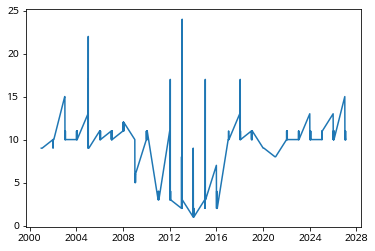

In [111]:
# X['시간']= pd.to_datetime(X['시간'])


In [120]:
#하루에 빛이 없는 시간( =소등시간)이 얼마나되는지

def get_night_time(x):
    X_light_zero = x[x['시간당총광량']==0]
    X_count = X_light_zero.groupby(X_light_zero.index.date).count()

    X =X_count.iloc[:,0]
    X.columns = ['소등시간']
    # X= pd.DataFrame(X)
    return X #결과물은 시리즈로 출력
get_night_time(X)

2001-01-01     9
2001-01-02     9
2001-01-03     9
2001-01-04     9
2001-01-05     9
              ..
2027-01-24    10
2027-01-25    10
2027-01-26    10
2027-01-27    10
2027-01-28    10
Name: 내부온도관측치, Length: 755, dtype: int64

위의 결과로 소등시간이 일자 별로 다른 것을 확인 

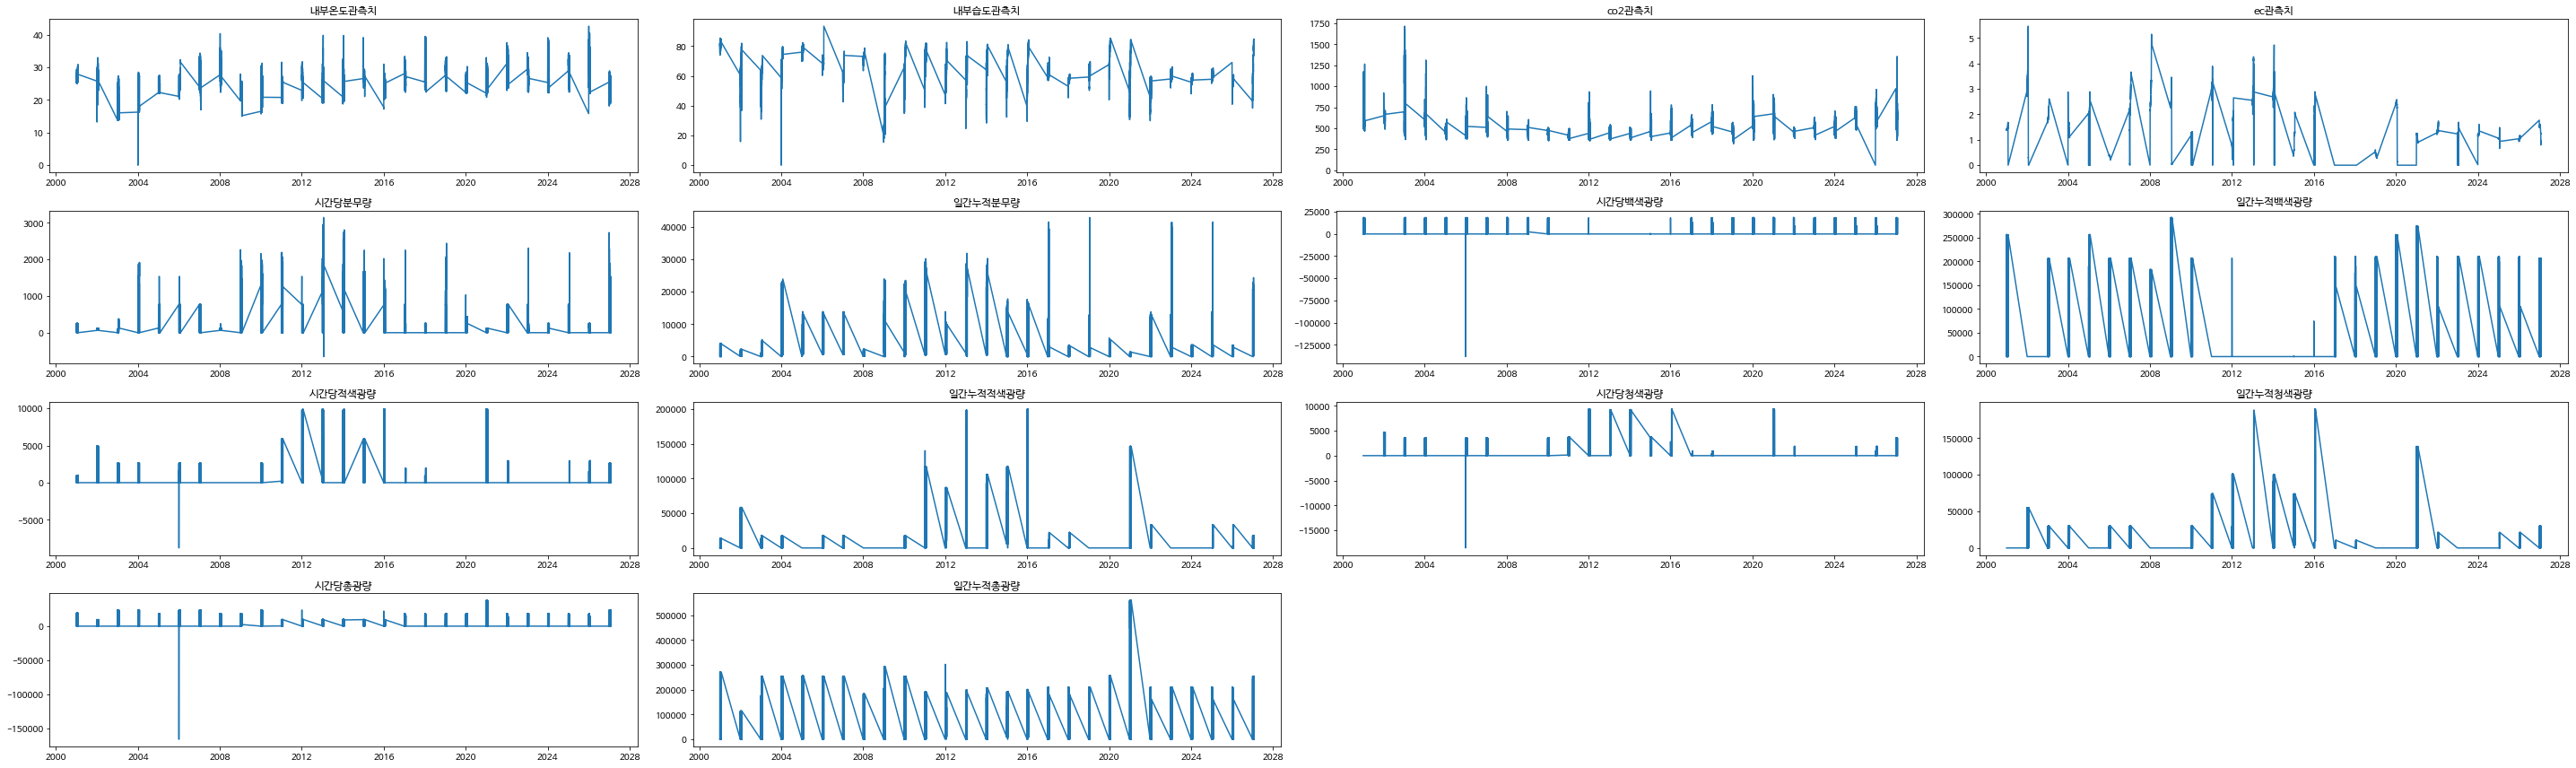

In [78]:
plt.figure(figsize=(40, 12))
for col in X.columns: 

    plt.subplot(4,4,list(X.columns).index(col)+1)
    plt.tight_layout()
    plt.title(col)
    plt.plot(X.index, X[col])
# plt.subplot(2,7,2)

# plt.plot(X.index, X['내부습도관측치'])    

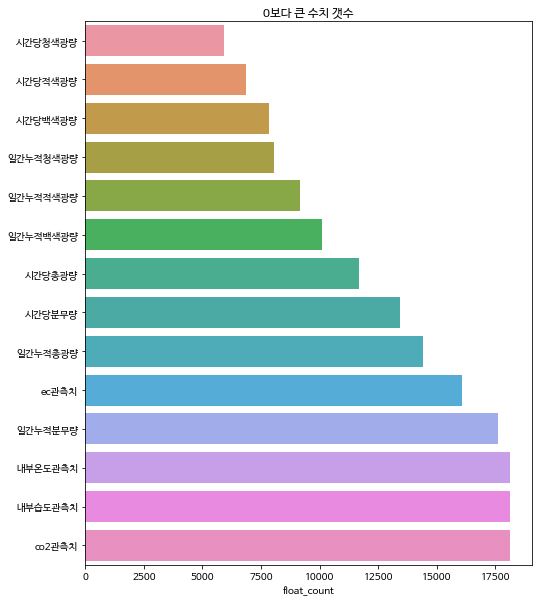

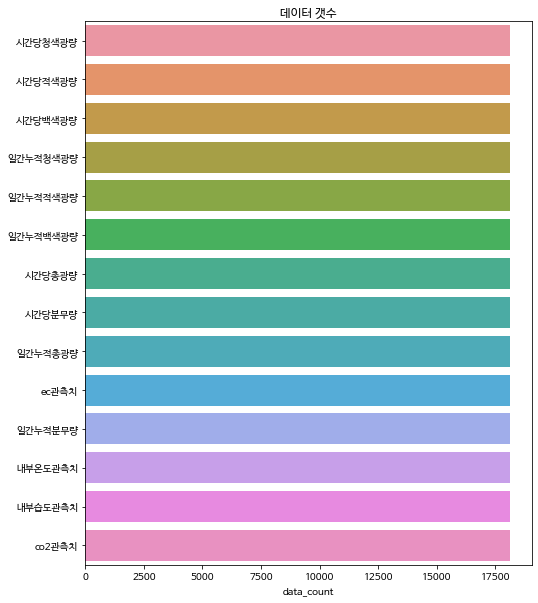

In [79]:
train_x, train_y = LoadData('train').read_train_raw()                           # train데이터를 전처리 없이 읽어온다.

data_count = (train_x.isnull()==False).sum()
null_count = (train_x.isnull()==True).sum()
float_count = (train_x.fillna(0).astype(bool)).sum()
data = [null_count, float_count, data_count]
index = ['null_count','float_count','data_count']
df = pd.DataFrame(data=data, index=index).T

df = df.sort_values('float_count')                                              # 수치 갯수 순으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('0보다 큰 수치 갯수')
sns.barplot(y=df.index, x=df['float_count'])                                    # 막대그래프를 그린다.
plt.show()

df = df.sort_values('data_count')                                               # 데이터 갯수 기준으로 정렬하여
plt.figure(figsize=(8,10))
plt.title('데이터 갯수')
sns.barplot(y=df.index, x=df['data_count'])                                     # 막대그래프를 그린다.
plt.show()

In [ ]:
def get_diff(x):
    x_diff =x.copy(deep =True)
    

,predicted_weight_g
시간,
1970-01-01 00:00:00.000000001,0.167719
1970-01-01 00:00:00.000000002,0.181787
1970-01-01 00:00:00.000000003,0.265921
1970-01-01 00:00:00.000000004,0.423650
1970-01-01 00:00:00.000000005,0.475272
1970-01-01 00:00:00.000000006,1.941879
1970-01-01 00:00:00.000000007,2.330901
1970-01-01 00:00:00.000000008,3.503249
1970-01-01 00:00:00.000000009,4.458239


In [123]:
def run_lgb(arg_params, train_X, train_y, val_X, val_y, test_X, test_Y):
    """
    arg_params를 하이퍼파라미터에 업데이트 한 후, train_X와 train_Y로 학습한 후 test_X로 추론을 해서 결과를 돌려준다.
    arg_params: LightGBM의 하이퍼파라메터를 딕셔너리 형태로 받아서, 병합한 뒤 실행한다.
    train_X, train_y: 학습용 데이터로 반드시 지정해야 한다.
    val_X, val_y: 검증용 데이터로 검증 데이터가 없는 경우 None으로 지정한다.
    test_X, test_Y: 학습후 테스트용 데이터로 test_X는 반드시 지정해야 하고, test_Y는 없는 경우 None으로 지정한다.
    """
    np.random.seed(SEED)
    random.seed(SEED)

    params = {
        'boosting': 'gbdt',
        "objective" : "fair",
        "verbose" : 0,
        "metric" : METRIC,
        "num_leaves" : 63,
        "learning_rate" : 0.05,
        "feature_fraction" : 1.0,
        "num_boost_round": NUM_BOOST_ROUNDS,
        "max_bin": 511,
        'min_data_in_leaf': 20,
        'bagging_seed': SEED,
        'feature_fraction_seed': SEED,
        'data_random_seed': SEED,
        'objective_seed': SEED,
        'drop_seed': SEED,
        'seed': SEED,
    }
    params.update(arg_params)
    
    lgtrain = lgb.Dataset(train_X, label=train_y)
    lgval = [lgb.Dataset(val_X, label=val_y)] if (val_X is not None) else None  # val_X가 주어진 경우, lgb.Dataset객체를 만든다.
    evals_result = {}

    model = lgb.train(params, lgtrain,
                      verbose_eval=False,
                      valid_sets=lgval,
                      evals_result=evals_result,
                      categorical_feature=categoricals
                      )    

    mfi = model.feature_importance(importance_type='gain')                      # 각 피처의 중요도를 조회한다.
    fi = pd.Series(mfi / mfi.sum(), index=model.feature_name()).to_frame()      # 전체 중요도 중 각 피처의 중요도 비율을 계산한다.

    pred_Y = model.predict(test_X)                                              # test_X의 label을 추론한다.

    if (test_Y is not None):                                                    # test_Y가 주어졌다면
        cv_preds = test_Y.iloc[:,0].to_frame('test_Y').assign(prediction=pred_Y)    # test_Y와 추론결과를 병합하여 돌려준다.
    else:
        cv_preds = pd.DataFrame(pred_Y, index=test_X.index, columns=['prediction']) # 아니면 추론결과만 돌려준다.

    return model, evals_result, fi, cv_preds

In [124]:
def tuning_max_bin():
    """
    train, validation, testing 세트로 이루어진 학습데이터를 읽은 후,
    LightBGM의 max_bin 하이퍼파라미터를 511, 2047, 4095로 변경하면서 RMSE를 계산해서,
    RMSE가 가장 적은 max_bin을 돌려준다.
    """
    train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

    rmse_list = []
    max_bin_list = [511, 2047, 4095]

    for max_bin in max_bin_list:
        params = {'max_bin':max_bin, "verbose" : -1}                            # warning 메시지를 표시하지 않도록 한다.

        _, _, _, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)

        rmse = np.sqrt(mean_squared_error(np.expm1(tst_y), np.expm1(cv_preds['prediction'])))
        rmse_list.append(rmse)
        print(f'max_bin:{max_bin:4d}. RMSE:{rmse:7.3f}')

    max_bin = max_bin_list[rmse_list.index(min(rmse_list))]
    print(f'Best max_bin: {max_bin}')

    return max_bin

max_bin: 511. RMSE: 17.308
max_bin:2047. RMSE: 17.308
max_bin:4095. RMSE: 17.308
Best max_bin: 511


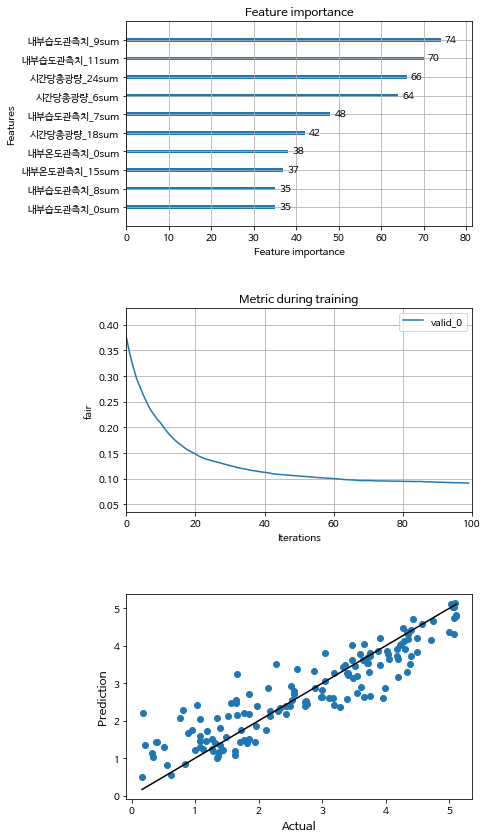

Features Importance Split & Gain...
           feature  split       gain
53   내부습도관측치_13sum     17  10.112020
37    내부습도관측치_9sum     74   7.026566
60   내부온도관측치_15sum     37   6.094139
49   내부습도관측치_12sum     14   5.494155
27     시간당총광량_6sum     64   5.469229
41   내부습도관측치_10sum     31   4.679253
45   내부습도관측치_11sum     70   4.632236
75    시간당총광량_18sum     42   4.006243
40   내부온도관측치_10sum     29   3.363873
56   내부온도관측치_14sum     31   3.291843
65   내부습도관측치_16sum     21   3.106241
31     시간당총광량_7sum     34   2.411824
63    시간당총광량_15sum     25   1.801376
44   내부온도관측치_11sum     24   1.675788
29    내부습도관측치_7sum     48   1.578515
99    시간당총광량_24sum     66   1.495054
67    시간당총광량_16sum     11   1.259563
43    시간당총광량_10sum     12   1.194731
33    내부습도관측치_8sum     35   1.186085
50     ec관측치_12sum     15   0.997710
39     시간당총광량_9sum     18   0.982163
35     시간당총광량_8sum     25   0.942752
94     ec관측치_23sum     17   0.907227
100        내부온도관측치      4   0.900675
79    시간당총광량_19sum     19   0.892127
0 

In [129]:
def plot_results(model, evals_result, test_Y, pred_test_y):
    """
    학습된 모델(model)의 평가결과(evals_result)를 표시한다.
    """
    fig, axes = plt.subplots(3, figsize=(8,12))
    fig.subplots_adjust(hspace=.4)

    lgb.plot_importance(model, max_num_features=10, ax=axes[0])                 # 첫번째 그래프: 상위 10개의 피처 중요도

    lgb.plot_metric(evals_result, metric=METRIC, ax=axes[1])                    # 두번째 그래프: metric 측정 결과

    axe = axes[2]                                                               # 세번째 그래프: 실측치와 예측치의 상관도
    axe.scatter(test_Y, pred_test_y)
    axe.plot([test_Y.min(), test_Y.max()], [test_Y.min(), test_Y.max()], color='k')
    axe.set_xlabel('Actual', size=12)
    axe.set_ylabel('Prediction', size=12)

    plt.subplots_adjust(top=0.96, bottom=0.06, left=0.3)
    plt.show()

    print("Features Importance Split & Gain...")
    gain = model.feature_importance('gain')
    featureimp = pd.DataFrame({'feature':model.feature_name(), 
                    'split':model.feature_importance('split'), 
                    'gain':100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    print(featureimp[:50])
    return


max_bin = tuning_max_bin()
train_x, train_y, val_x, val_y, tst_x, tst_y = load_spilit_train()

params = {'max_bin':max_bin, "verbose" : -1}                                    # warning 메시지를 표시하지 않도록 한다.
model, evals_result, fi, cv_preds = run_lgb(params, train_x, train_y, val_x, val_y, tst_x, tst_y)
plot_results(model, evals_result, tst_y, cv_preds['prediction'])

test_Y = np.expm1(tst_y)
pred_Y = np.expm1(cv_preds['prediction'])

MAE = mean_absolute_error(test_Y, pred_Y)
MSE = mean_squared_error(test_Y, pred_Y)
RMSE = np.sqrt(mean_squared_error(test_Y, pred_Y))

print(f"MAE: {MAE:6.3f}, MSE: {MSE:6.3f}, RMSE: {RMSE:6.3f}")